## Introduction on how to use the code and train parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scipy.linalg
import scipy.spatial.distance as sd
import numpy as np
import scipy.integrate
import pandas as pd


import matplotlib.pyplot as plt

/Users/watakani/miniconda3/envs/py/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.data import get_linear_data, get_quad_data, get_nonlinear_data,duffing_oscilator,hopf
from src.edmd import TruncEDMD, KernelEDMD, DMD
from src.kernels import RBFKernel, LinearKernel, PolynomialKernel
from src.training_edmd import GD_edmd_training
from src.visualizations import  OOS_tradjectory, plot_2D_dynamic_system
from scipy.integrate import odeint
#from datafold.pcfold import GaussianKernel, TSCDataFrame
from scipy.integrate import solve_ivp

In [4]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Define functions for plotting the output

Then initialize EDMD class, either using the kernel to explicitly define the dictionary (KernelEDMD), or implictly through truncated SVD (TruncEDMD).

Generate and plot data with a random linear evolution operator A and plot it if 2D

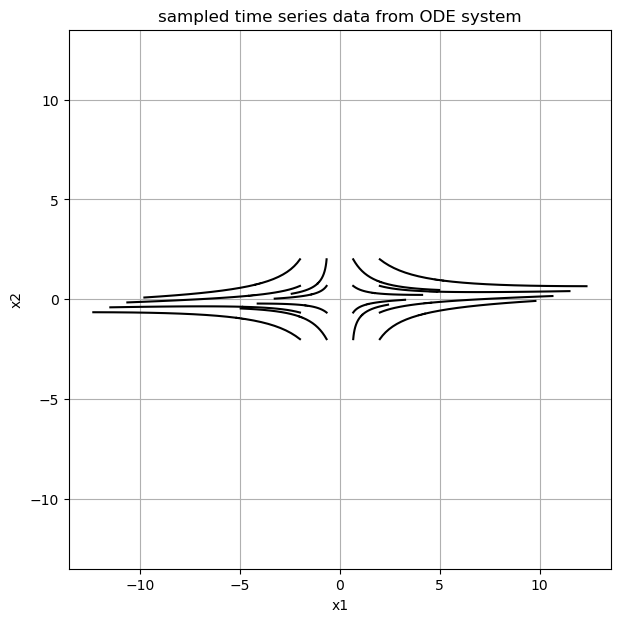

In [5]:
#linear
fig, ax = plt.subplots(figsize=[7, 7])
dim=2
timesteps=21
t_end=0.4
t_eval=np.linspace(0, t_end, timesteps)

initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2,4), np.linspace(-2, 2,4))).T.reshape(-1, 2)
np.random.seed(3)
x = np.empty((len(initial_conditions)*(timesteps-1), 2))
y = np.empty((len(initial_conditions)*(timesteps-1), 2))
#A = np.array([[1, -1],[1,1]])
A = np.random.standard_normal(size=(dim, dim))

for ic, condition in enumerate(initial_conditions):
    solution,df, _,_=get_linear_data(t_eval, condition, dim,A)
    x[ic*(timesteps-1) :ic*(timesteps-1)+timesteps-1, :]=solution[:-1,:]
    y[ic*(timesteps-1) :ic*(timesteps-1)+timesteps-1, :]=solution[1:,:]
    if x.shape[1] ==2:     
        plot_2D_dynamic_system(ax,df)
#Add labels to plot
ax.set_title("sampled time series data from ODE system")
ax.grid()


Create and Plot nonlinear Dynamic system if the system is 2D also plot it (replaces linear system) Attempt 1

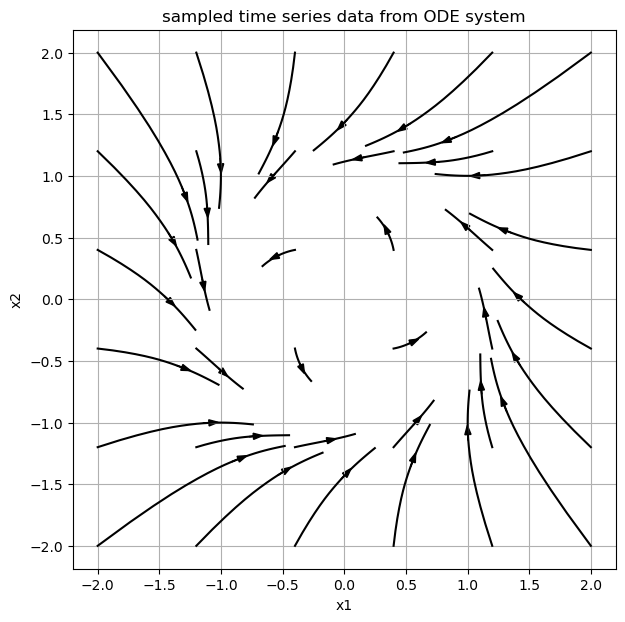

In [6]:
fig, ax = plt.subplots(figsize=[7, 7])
timesteps=21
t_end=0.4
t_eval=np.linspace(0, t_end, timesteps)
df_Original=pd.DataFrame()

initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2,6), np.linspace(-2, 2, 6))).T.reshape(-1, 2)
x = np.empty((len(initial_conditions)*(timesteps-1), 2))
y = np.empty((len(initial_conditions)*(timesteps-1), 2))

#equation options: duffing_oscilator, hopf
#loop over initial conditions
for ic, condition in enumerate(initial_conditions):
    
    solution,df=get_nonlinear_data(t_eval,condition,hopf)
    df_Original=pd.concat([df_Original,df],ignore_index=True)

    x[ic*(timesteps-1) :ic*(timesteps-1)+(timesteps-1), :]=solution[:-1,:]
    y[ic*(timesteps-1) :ic*(timesteps-1)+(timesteps-1), :]=solution[1:,:]
    #if ic == 0: print(df)
    if x.shape[1] ==2:
        plot_2D_dynamic_system(ax,df)
#Add labels to plot
ax.set_title("sampled time series data from ODE system")
ax.grid()

#for ic, cond in enumerate(initial_conditions):
#    print(ic, cond)

Perform Classical DMD


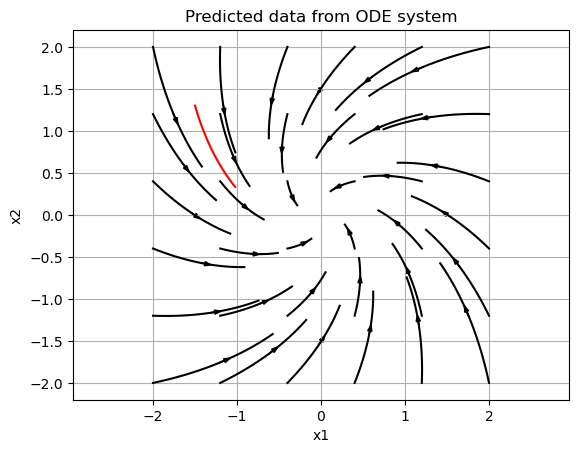

In [7]:

fig, ax = plt.subplots()
method=DMD()
df_DMD_classic=pd.DataFrame()


DMD_classic_results=method.compute_K_DMD(x.T,y.T)

for ic,condition in enumerate(initial_conditions):
    condition=np.array([condition],ndmin=2)

    Fx=method.single_tradjectory(t_eval,condition,)
    df=pd.DataFrame(data=Fx, index=t_eval,columns =['x1','x2'])
    df_DMD_classic=pd.concat([df_DMD_classic,df],ignore_index=True)
   
    if x.shape[1] ==2:
        plot_2D_dynamic_system(ax,df)
t_eval_sample = np.linspace(0, 1000, timesteps)
ax,_=OOS_tradjectory(t_eval_sample,np.array([-1.5,1.3]),method,ax,None,x,y,DMD_classic_results)

#Add labels to plot
ax.set_title("Predicted data from ODE system")
ax.grid()


Perform Kernel DMD

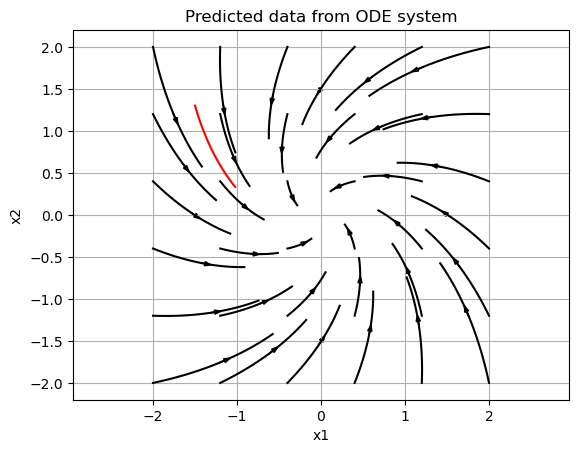

In [8]:


method = TruncEDMD()
kernel =LinearKernel()
fig, ax = plt.subplots()
df_DMD_Kernel=pd.DataFrame(columns =np.array( ['x1','x2']))

Linear_Kernel_results=method.edmd_computations(x.T,y.T,kernel)
a = method.K
for ic,condition in enumerate(initial_conditions):
    condition=np.array([condition],ndmin=2)

    Fx=method.single_tradjectory(t_eval,condition.T,x.T,y.T,kernel)

    df=pd.DataFrame(data=Fx, index=t_eval,columns =np.array( ['x1','x2']) )
    df_DMD_Kernel=pd.concat([df_DMD_Kernel,df],ignore_index=True)
    if x.shape[1] ==2:
        plot_2D_dynamic_system(ax,df)


ax,_= OOS_tradjectory(t_eval,np.array([-1.5,1.3]),method,ax,kernel,x,y,Linear_Kernel_results)       
    
    #Add labels to plot
ax.set_title("Predicted data from ODE system")
ax.grid()





Perform Kernel EDMD using Polynomial Kernel

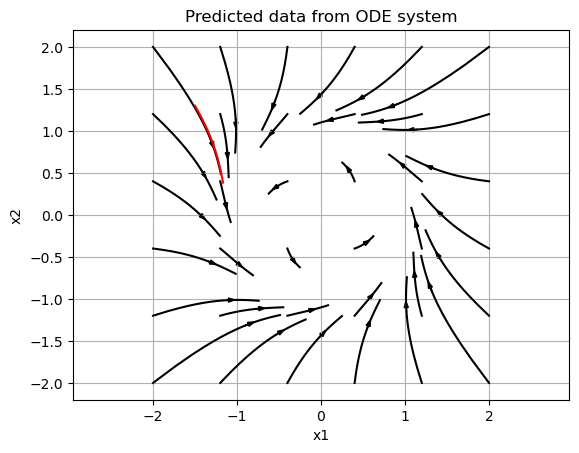

In [9]:

#x_next_DMD=edmd.trajectory_visualization_DMD(x,y,LinearKernel())
method = TruncEDMD()
kernel =PolynomialKernel()
fig, ax = plt.subplots()
df_PolynomialKernel=pd.DataFrame(columns =np.array( ['x1','x2']))

Polynomial_Kernel_results=method.edmd_computations(x.T,y.T,kernel)
for ic,condition in enumerate(initial_conditions):
    condition=np.array([condition],ndmin=2)
    #Fx=edmd.single_tradjectory(t_eval,condition,x,y,K,SVD_x,koop_modes,eigen_decomp,LinearKernel())
    Fx=method.single_tradjectory(t_eval,condition.T, x.T, y.T, kernel)

    df=pd.DataFrame(data=Fx, index=t_eval,columns =np.array( ['x1','x2']) )
    df_PolynomialKernel=pd.concat([df_PolynomialKernel,df],ignore_index=True)

    if x.shape[1] ==2:
        plot_2D_dynamic_system(ax,df)
        
ax,_= OOS_tradjectory(t_eval,np.array([-1.5,1.3]),method,ax,kernel,x,y,Polynomial_Kernel_results) 

ax.set_title("Predicted data from ODE system")
ax.grid()




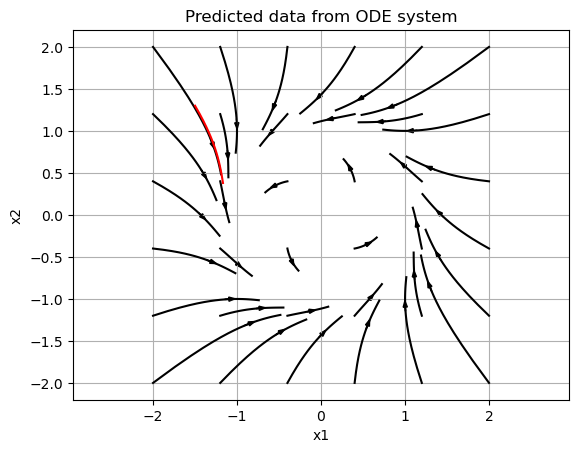

In [10]:

#x_next_DMD=edmd.trajectory_visualization_DMD(x,y,LinearKernel())
method = TruncEDMD()
parameter = torch.tensor(0.999, requires_grad=True)
kernel = RBFKernel([parameter])
fig, ax = plt.subplots()


RBF_Kernel_results=method.edmd_computations(x.T,y.T,kernel)
for ic,condition in enumerate(initial_conditions):
    condition=np.array([condition],ndmin=2)

    Fx=method.single_tradjectory(t_eval,condition.T,x.T,y.T,kernel)
    df=pd.DataFrame(data=Fx, index=t_eval,columns =np.array( ['x1','x2']) )
    

    if x.shape[1] ==2:
        plot_2D_dynamic_system(ax,df)
        
ax,_=OOS_tradjectory(t_eval,np.array([-1.5,1.3]),method,ax,kernel,x,y,RBF_Kernel_results) 

ax.set_title("Predicted data from ODE system")
ax.grid()


Now we can use GD to train the parameter of the kernel. We can train using the full loss, or the eigen loss. Adding a penalty term that avoids trivial solutions. We run the full scheme 50 times, with one gradient step for each turn. We receive the loss, and the parameter value can be found from the kernel object.

[Parameter containing:
tensor(0.5000, requires_grad=True)]


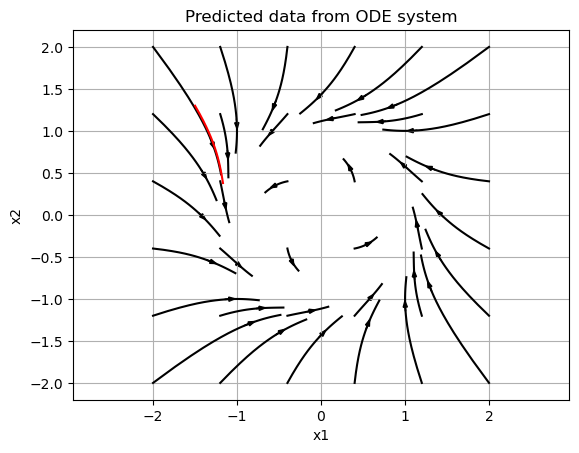

In [11]:
method = TruncEDMD()
parameter = torch.tensor(0.5, requires_grad=True)
kernel = RBFKernel([parameter])

print(list(kernel.parameters()))


fig, ax = plt.subplots()
df_RBFKernel=pd.DataFrame(columns =np.array( ['x1','x2']))

RBF_Kernel_results=method.edmd_computations(x.T,y.T,kernel)
for ic,condition in enumerate(initial_conditions):
    condition=np.array([condition],ndmin=2)

    Fx=method.single_tradjectory(t_eval,condition.T,x.T,y.T,kernel)
    df=pd.DataFrame(data=Fx, index=t_eval,columns =np.array( ['x1','x2']) )
    df_RBFKernel=pd.concat([df_RBFKernel,df],ignore_index=True)
 
    if x.shape[1] ==2:
        plot_2D_dynamic_system(ax,df)


ax, _ = OOS_tradjectory(t_eval,np.array([-1.5,1.3]),method,ax,kernel,x,y,RBF_Kernel_results) 

    #Add labels to plot
ax.set_title("Predicted data from ODE system")
ax.grid()


Perform EDMD-DL 

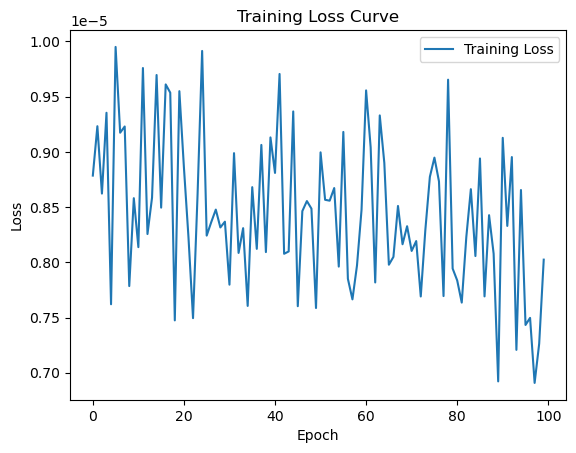

In [12]:
#loss, num_epochs = GD_edmd_training(1000, 1, x_nonlin, y_nonlin, kernel, edmd, full=True, penalty=False)
loss, num_epochs = GD_edmd_training(100, 1, x.T, y.T, kernel, method, lr=1e-1, full=True, penalty=True)
#plot the loss
fig, ax = plt.subplots()
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()



[Parameter containing:
tensor(0.5031, requires_grad=True)]


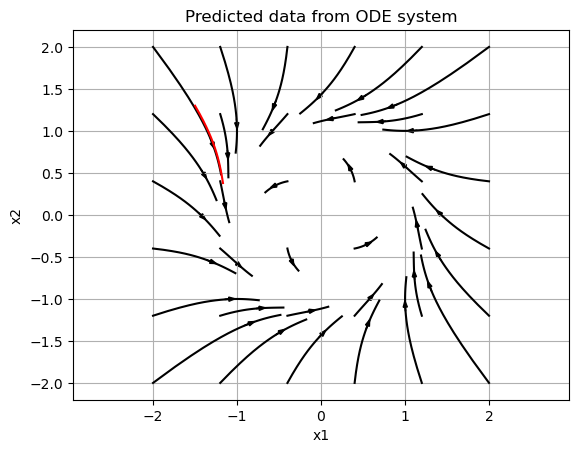

In [13]:
print(list(kernel.parameters()))


fig, ax = plt.subplots()
df_RBFKernel=pd.DataFrame(columns =np.array( ['x1','x2']))

RBF_Kernel_results=method.edmd_computations(x.T,y.T,kernel)
for ic,condition in enumerate(initial_conditions):
    condition=np.array([condition],ndmin=2)

    Fx=method.single_tradjectory(t_eval,condition.T,x.T,y.T,kernel)
    df=pd.DataFrame(data=Fx, index=t_eval,columns =np.array( ['x1','x2']) )
    df_RBFKernel=pd.concat([df_RBFKernel,df],ignore_index=True)
 
    if x.shape[1] ==2:
        plot_2D_dynamic_system(ax,df)


ax, _ = OOS_tradjectory(t_eval,np.array([-1.5,1.3]),method,ax,kernel,x,y,RBF_Kernel_results) 

    #Add labels to plot
ax.set_title("Predicted data from ODE system")
ax.grid()




Text(0.5, 1.0, 'RBF EDMD Solution')

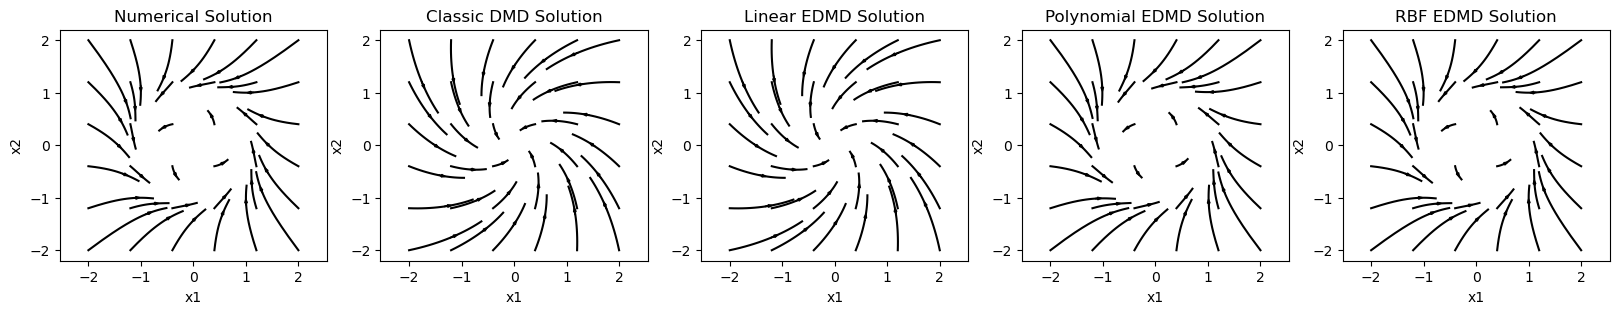

In [14]:
f, ax = plt.subplots(1, 5, figsize=(20, 3))

for ic,condition in enumerate(initial_conditions):
    
    
    if x.shape[1] ==2:   
        plot_2D_dynamic_system(ax[0],df_Original.iloc[ic*(timesteps) :ic*(timesteps)+(timesteps-1)])  
        plot_2D_dynamic_system(ax[1],df_DMD_classic.iloc[ic*(timesteps) :ic*(timesteps)+(timesteps-1)])
        plot_2D_dynamic_system(ax[2],df_DMD_Kernel.iloc[ic*(timesteps) :ic*(timesteps)+(timesteps-1)])
        plot_2D_dynamic_system(ax[3],df_PolynomialKernel.iloc[ic*(timesteps) :ic*(timesteps)+(timesteps-1)])
        plot_2D_dynamic_system(ax[4],df_RBFKernel.iloc[ic*(timesteps) :ic*(timesteps)+(timesteps-1)])



ax[0].set_title("Numerical Solution")
ax[1].set_title("Classic DMD Solution")
ax[2].set_title("Linear EDMD Solution")
ax[3].set_title("Polynomial EDMD Solution")
ax[4].set_title("RBF EDMD Solution")

Compare the classical numerical and EDMD-DL predictions

335.59315354631383
335.59315354630735
393.72863598124195
394.7754507348914


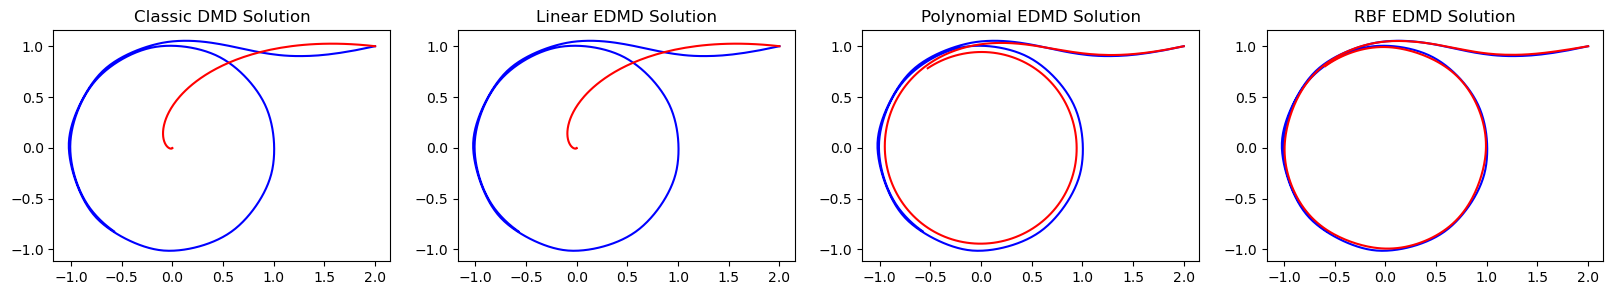

In [22]:
#generate an out of sample prediction
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
timesteps_sample=400
t_end_sample =5
t_eval_sample = np.linspace(0, t_end_sample, timesteps_sample)
initial_condition_sample=np.array([2,1])
if x.shape[1] ==2:  
        actual,_=get_nonlinear_data(t_eval_sample,initial_condition_sample,hopf)
        ax[0].plot(actual[:,0], actual[:,1], 0.1, c="blue")
        ax[1].plot(actual[:,0], actual[:,1], 0.1, c="blue")
        ax[2].plot(actual[:,0], actual[:,1], 0.1, c="blue")
        ax[3].plot(actual[:,0], actual[:,1], 0.1, c="blue")
      
        ax[0],predicted_dmd = OOS_tradjectory(t_eval_sample,initial_condition_sample,DMD(),ax[0],None,x,y,DMD_classic_results) 
        ax[1],predicted_lin = OOS_tradjectory(t_eval_sample,initial_condition_sample,TruncEDMD(),ax[1],LinearKernel(),x,y,Linear_Kernel_results)
        ax[2],predicted_poly = OOS_tradjectory(t_eval_sample,initial_condition_sample,TruncEDMD(),ax[2],PolynomialKernel(),x,y,Polynomial_Kernel_results) 
        ax[3],predicted_rbf = OOS_tradjectory(t_eval_sample,initial_condition_sample,TruncEDMD(),ax[3],RBFKernel([parameter]),x,y,RBF_Kernel_results) 
        
        ax[0].set_title("Classic DMD Solution")
        ax[1].set_title("Linear EDMD Solution")
        ax[2].set_title("Polynomial EDMD Solution")
        ax[3].set_title("RBF EDMD Solution")

#Compute Relative L2 Error
l2_norm_dmd = np.sum(np.power((actual-predicted_dmd),2))
l2_norm_lin = np.sum(np.power((actual-predicted_lin),2))  
l2_norm_poly = np.sum(np.power((actual-predicted_poly),2))  
l2_norm_rbf = np.sum(np.power((actual-predicted_rbf),2))     
print(l2_norm_dmd)    
print(l2_norm_lin)    
print(l2_norm_poly)    
print(l2_norm_rbf)    

